City and date indicators
* city – City abbreviations: sj for San Juan and iq for Iquitos
* week_start_date – Date given in yyyy-mm-dd format

NOAA's GHCN daily climate data weather station measurements
* station_max_temp_c – Maximum temperature
* station_min_temp_c – Minimum temperature
* station_avg_temp_c – Average temperature
* station_precip_mm – Total precipitation
* station_diur_temp_rng_c – Diurnal temperature range

PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
* precipitation_amt_mm – Total precipitation

NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
* reanalysis_sat_precip_amt_mm – Total precipitation
* reanalysis_dew_point_temp_k – Mean dew point temperature
* reanalysis_air_temp_k – Mean air temperature
* reanalysis_relative_humidity_percent – Mean relative humidity
* reanalysis_specific_humidity_g_per_kg – Mean specific humidity
* reanalysis_precip_amt_kg_per_m2 – Total precipitation
* reanalysis_max_air_temp_k – Maximum air temperature
* reanalysis_min_air_temp_k – Minimum air temperature
* reanalysis_avg_temp_k – Average air temperature
* reanalysis_tdtr_k – Diurnal temperature range

Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
* ndvi_se – Pixel southeast of city centroid
* ndvi_sw – Pixel southwest of city centroid
* ndvi_ne – Pixel northeast of city centroid
* ndvi_nw – Pixel northwest of city centroid

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data_path = []
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data_path.append(os.path.join(dirname, filename))
        


.\dengue_analyze.py
.\dengue_features_train.csv
.\dengue_labels_train.csv
.\Untitled.ipynb
.\.ipynb_checkpoints\Untitled-checkpoint.ipynb


In [22]:
df_feat = pd.read_csv(data_path[1])
df_targ = pd.read_csv(data_path[2])
#print(df_targ.columns)
df_o=pd.concat([df_feat,df_targ.total_cases],axis=1)
#df_o.sample(5)
df_o.columns


Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

## Data Exploration

In [23]:
# Data are mostly floats, with a couple ints and a couple objects
print('\n Rows and Columns:')
print(df_o.shape)
print('\n Data Types:')
print(df_o.dtypes)


 Rows and Columns:
(1456, 25)

 Data Types:
city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c      

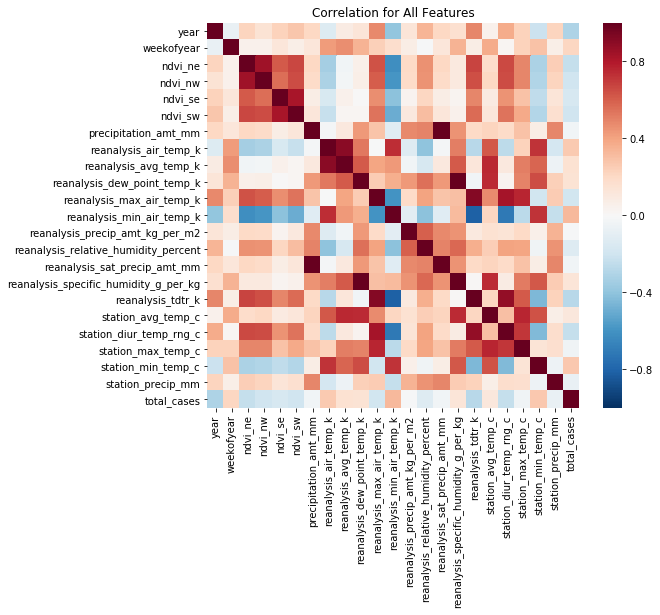

In [89]:
import seaborn as sn

def plot_corr_matrix(df=df, subset=[], details="All Features"):

    if len(subset)>0:
        df = df[subset]
        
    corr = df.corr()
    #cmap = sn.diverging_palette(255, 133, l=60, n=7, center="dark")
    
    xx=(df.shape[1]/3,(df.shape[1]/3)*.85 )
    fig=plt.figure(figsize=xx)
    ax = sn.heatmap(corr,cmap='RdBu_r',vmin=-1,vmax=1)

    ax.set_title("Correlation for "+details)
    
plot_corr_matrix(df=df_o, subset=[], details="All Features") 

25

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

In [91]:
# Create working copy of the data for cleaning (df_o to remain unchanged)
df = df_o.copy()
df.isnull().sum().sort_values(ascending=False)
#len(df)

station_diur_temp_rng_c                  43
station_avg_temp_c                       43
station_precip_mm                        22
station_max_temp_c                       20
station_min_temp_c                       14
precipitation_amt_mm                     13
reanalysis_sat_precip_amt_mm             13
reanalysis_max_air_temp_k                10
reanalysis_air_temp_k                    10
reanalysis_avg_temp_k                    10
reanalysis_dew_point_temp_k              10
reanalysis_precip_amt_kg_per_m2          10
reanalysis_min_air_temp_k                10
reanalysis_relative_humidity_percent     10
reanalysis_specific_humidity_g_per_kg    10
reanalysis_tdtr_k                        10
ndvi_ne                                   0
year                                      0
weekofyear                                0
week_start_date                           0
total_cases                               0
ndvi_nw                                   0
ndvi_se                         

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025814C3C160>,
      dtype=object)

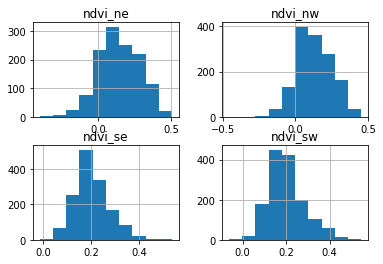

In [65]:
df[["ndvi_se","ndvi_sw","ndvi_ne","ndvi_nw"]].hist()

We could drop ndvi_ne as it is highly correlated with ndvi_nw, however currently we will try imputing with the mean of the other 3 ndvi variables. The 52 cases where ndvi_nw is missing, we will replace with the mean of ndvi_se and ndvi_sw. Where ndvi_se and ndvi_s are missing, we will impute with the mean. 

In [67]:
df.ndvi_se.fillna(df.ndvi_se.mean(),inplace=True)
df.ndvi_sw.fillna(df.ndvi_sw.mean(),inplace=True)
df.ndvi_nw.fillna((df.ndvi_sw + df.ndvi_se)/2,inplace=True)
df.ndvi_ne.fillna((df.ndvi_sw + df.ndvi_se + df.ndvi_nw)/3,inplace=True)

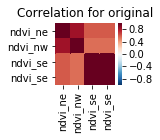

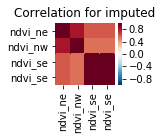

In [90]:
# Check the correlation matrices for the ndvi features, before and after imputation
plot_corr_matrix(df=df_o, subset=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_se'], details="original") 
plot_corr_matrix(df=df, subset=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_se'], details="imputed") 

In [45]:
def lin_reg(x,y, features=[],do_scale=True, show_cm=False,normTF=True):
    
    if len(features)>0:
        x=x[features]
    
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.2,random_state=3)
    
    model = LinearRegression()
    if do_scale:
        classifier = Pipeline(steps = [('scaler',StandardScaler()),('model',model)])
    else:
        classifier = Pipeline(steps = [('model',model)])
        
    classifier.fit(x_train,y_train)
    
    #scores = cross_val_score(classifier, x, y, cv=5, scoring='mean_squared_error')
    #print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [46]:

x = df.copy()
x.drop("total_cases", axis=1, inplace=True)
y = df.total_cases

# Baseline Linear regression, no bell/whistles, to get a starting point
lin_reg(x,y)

ValueError: could not convert string to float: 'sj'